In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('C:/Python/Data_Files/IMOEX_150829_200829.csv', sep=',', header=None)
data = pd.DataFrame()
data[0] = raw_data[0]

In [3]:
data['rank']=(data[0].rank(method='first'))/(len(data))
data=data.sort_values(by='rank').reset_index(drop=True)

In [4]:
mean = np.average(data[0])
med = np.median(data[0])
std = np.std(data[0])
var = std**2
skew = sps.skew(data[0])
kurt = sps.kurtosis(data[0])

In [5]:
loc_laplace = med
scale_laplace = np.average(abs(data[0]-med))

In [6]:
loc_cauchy = med
scale_cauchy = (np.percentile(data[0],0.75)-np.percentile(data[0],0.25))/2

In [7]:
def cauchy_mle(k):
    return -np.sum(np.log(1/(np.pi*k[1]*(1 + ((data[0]-k[0])/k[1])**2))))
res = spop.minimize(cauchy_mle, [loc_cauchy, scale_cauchy], method='Powell')
loc_cauchy_mle = res.x[0]
scale_cauchy_mle = res.x[1]

C:\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
def hypersecant_mle(k):
    return -np.sum(np.log(np.pi/(k[1])*np.exp(np.pi/2*(data[0]-k[0])/k[1])/(1+np.exp(np.pi*(data[0]-k[0])/k[1]))))
res = spop.minimize(hypersecant_mle, [mean, std], method='Powell')
loc_hypersecant_mle = res.x[0]
scale_hypersecant_mle = res.x[1]

C:\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
loc_logistic = mean
scale_logistic = 3**(1/2)/np.pi*std

In [10]:
def logistic_mle(k):
    return -np.sum(np.log(np.exp(-(data[0]-k[0])/k[1])/(k[1]*(1+np.exp(-(data[0]-k[0])/k[1]))**2)))
res = spop.minimize(logistic_mle, [loc_logistic, scale_logistic], method='Powell')
loc_logistic_mle = res.x[0]
scale_logistic_mle = res.x[1]

In [11]:
df_student = 6/kurt + 4
loc_student = mean
scale_student = std*((df_student - 2)/df_student)**(1/2)

In [12]:
data['normal']=sps.norm.cdf(data[0],loc=mean,scale=std)
data['cauche-MM']=1/np.pi*np.arctan((data[0]-loc_cauchy)/scale_cauchy)+1/2
data['cauche-MLE']=1/np.pi*np.arctan((data[0]-loc_cauchy_mle)/scale_cauchy_mle)+1/2
data['laplace1']=1/2*np.exp((data[data[0]<=loc_laplace][0]-med)/scale_laplace)
data['laplace2']=1-1/2*np.exp(-(data[data[0]>med][0]-loc_laplace)/scale_laplace)
data['laplace']=data['laplace1'].replace(np.nan,0)+data['laplace2'].replace(np.nan,0)
data['hypersecant-MM']=2/np.pi*np.arctan(np.exp(np.pi*(data[0]-mean)/(2*std)))
data['hypersecant-MLE']=2/np.pi*np.arctan(np.exp(np.pi*(data[0]-loc_hypersecant_mle)/(2*scale_hypersecant_mle)))
data['student']=sps.t.cdf((data[0]-loc_student)/(scale_student),df_student,loc=0,scale=1)
data['log-MM']=1/(1+np.exp(-(data[0]-loc_logistic)/scale_logistic))
data['log-MLE']=1/(1+np.exp(-(data[0]-loc_logistic_mle)/scale_logistic_mle))


normal

supremum 0.0717
p-value is 0.0015
distribution does not fit


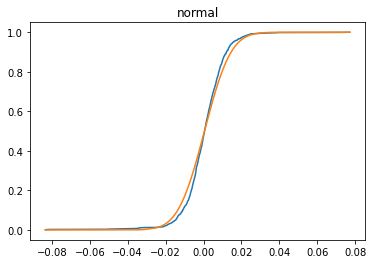


laplace

supremum 0.0328
p-value is 0.2585
distribution fits


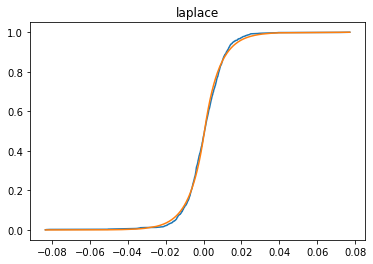


hypersecant-MM

supremum 0.0348
p-value is 0.2181
distribution fits


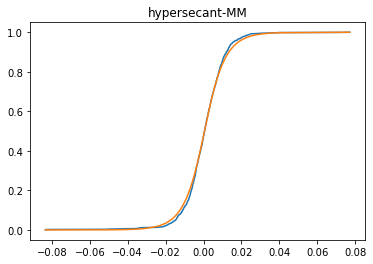


hypersecant-MLE

supremum 0.0166
p-value is 0.7071
distribution fits


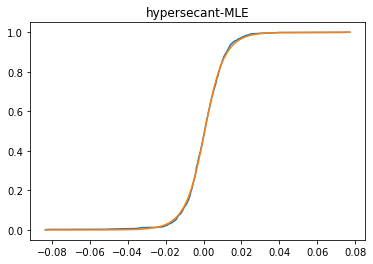


cauche-MM

supremum 0.1047
p-value is 0.0
distribution does not fit


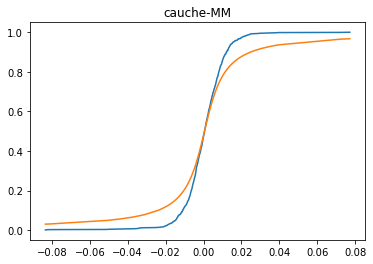


cauche-MLE

supremum 0.061
p-value is 0.0092
distribution does not fit


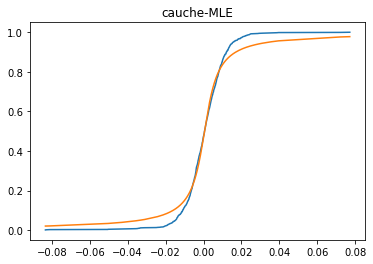


student

supremum 0.0277
p-value is 0.3804
distribution fits


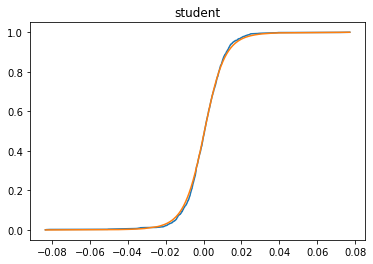


log-MM

supremum 0.0491
p-value is 0.0482
distribution does not fit


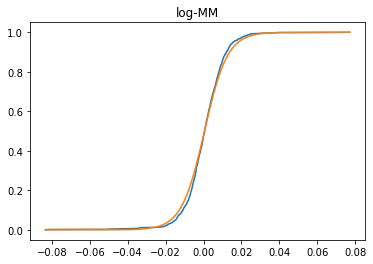


log-MLE

supremum 0.0232
p-value is 0.5082
distribution fits


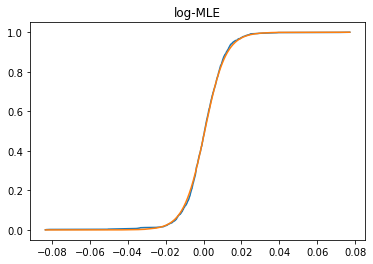

In [13]:
distributions = ['normal', 'laplace', 'hypersecant-MM', 'hypersecant-MLE', 'cauche-MM', 'cauche-MLE', 'student', 'log-MM', 'log-MLE']
for dist in distributions:
    
    KS_array = abs(data['rank']-data[dist])
    KS = max(KS_array)
    
    KS_p = np.exp(-KS**2*len(data))
    
    print()
    print(dist)
    print()
    print('supremum '+str(round(KS,4)))
    print('p-value is '+str(round(KS_p,4)))
    if KS_p > 0.1:
        print('distribution fits')
    else:
        print('distribution does not fit')
    plt.figure(dist)
    plt.plot(data[0],data['rank'])
    plt.plot(data[0],data[dist])
    plt.title(dist)
    plt.show()